In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
import time
from tqdm.notebook import tqdm
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Multiplexed readout

In [2]:
soc = qick.QickSoc(bitfile="/home/xilinx/jupyter_notebooks/qick_111_rfbv1_mux.bit")
#soc = qick.QickSoc(bitfile="/home/xilinx/jupyter_notebooks/qick_111_rfbv2.bit")
soccfg = soc
print(soc)


QICK configuration:

	Board: ZCU111

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 0, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 0, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 0, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 1, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 1, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC tile 1, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	6:	axis_sg_mux4_v2 - tProc output

In [3]:
class myQickProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        self.declare_gen(ch=cfg["res_ch"], nqz=cfg['nqz'],
                         mixer_freq=cfg["mixer_freq"],
                         mux_freqs=cfg["pulse_freqs"],
                         mux_gains=cfg["pulse_gains"],
                         ro_ch=cfg["ro_chs"][0])
        
        for iCh, ch in enumerate(cfg["ro_chs"]):  # configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, freq=cfg["pulse_freqs"][iCh],
                                 length=soccfg.us2cycles(cfg['length'], ro_ch=ch),
                                 gen_ch=cfg["res_ch"])
            
        self.synci(200)  # give processor some time to configure pulses


    def body(self):
        self.set_pulse_registers(ch=self.cfg["res_ch"], style="const",
                                 length=soccfg.us2cycles(
                                     self.cfg['length'], 
                                     gen_ch=self.cfg['res_ch']),
                                 mask=self.cfg["mask"])

        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

### Example (Time of Flight)
We can see that the program is working

{'name': 'synci', 'args': (200,)}
{'name': 'regwi', 'args': (0, 15, 0)}
{'name': 'regwi', 'args': (0, 14, 0)}
{'name': 'regwi', 'args': (4, 11, 384), 'comment': 'freq = 384', 'label': 'LOOP_J'}
{'name': 'regwi', 'args': (4, 12, 7), 'comment': 'mask = [0, 1, 2]'}
{'name': 'regwi', 'args': (0, 31, 28673), 'comment': 'out = 0b0111000000000001'}
{'name': 'seti', 'args': (0, 0, 31, 0), 'comment': 'ch =0 out = $31 @t = 0'}
{'name': 'seti', 'args': (0, 0, 0, 10), 'comment': 'ch =0 out = 0 @t = 0'}
{'name': 'regwi', 'args': (4, 16, 0), 'comment': 't = 0'}
{'name': 'set', 'args': (7, 4, 11, 12, 0, 0, 0, 16), 'comment': 'ch = 6, pulse @t = $16'}
{'name': 'waiti', 'args': (0, 384)}
{'name': 'synci', 'args': (192384,)}
{'name': 'mathi', 'args': (0, 15, 15, '+', 1)}
{'name': 'memwi', 'args': (0, 15, 1)}
{'name': 'loopnz', 'args': (0, 14, 'LOOP_J')}
{'name': 'end', 'args': ()}


  0%|          | 0/100 [00:00<?, ?it/s]

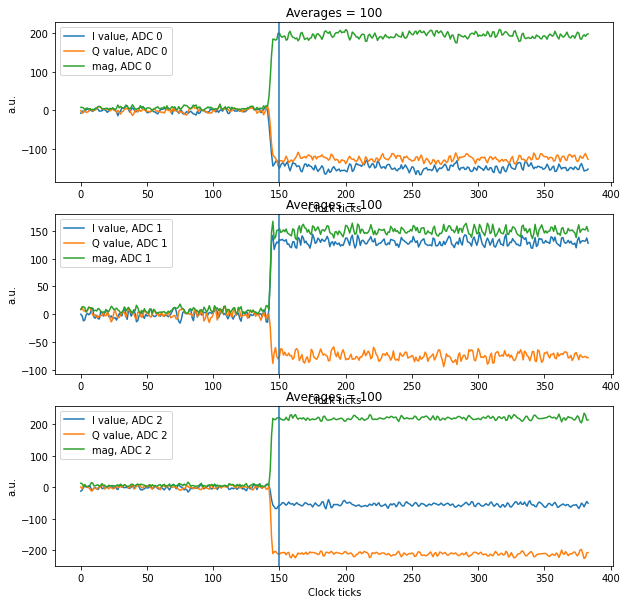

In [4]:
config = {
    'res_ch': 6,
    'ro_chs': [0,1,2],
    'nqz': 1,
    'mixer_freq': 0,
    'pulse_freqs': [45, 200, 380],
    'pulse_gains': [1.0, 1.0, 1.0],
    'pulse_style': 'const',
    'adc_trig_offset': 0,
    'length': 1,
    'relax_delay': 500,
    'reps': 1,
    'soft_avgs': 100,
    'mask': [0, 1, 2]
}

prog = myQickProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, 
                                 progress=True, debug=True)
# Plot results.
fig, axs = plt.subplots(3,1,figsize=(10,10))

for ii, iq in enumerate(iq_list):
    plot = axs[ii]
    plot.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plot.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plot.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
    plot.set_ylabel("a.u.")
    plot.set_xlabel("Clock ticks")
    plot.set_title("Averages = " + str(config["soft_avgs"]))
    plot.legend()
    plot.axvline(150)

### Resonator spectroscopy
The exact same qick program is used, but with different configuration parameters.

The amplitude seems to be correct (althought noisy). The phase seems a bit random

In [5]:
config = {
    'res_ch': 6,
    'ro_chs': [0, 1, 2],
    'nqz': 1,
    'mixer_freq': 0,
    'initials': np.array([201, 431, 540]),
    'pulse_gains': [.5, .5, .5],
    'pulse_style': 'const',
    'adc_trig_offset': 150,
    'length': 1,
    'relax_delay': 50,
    'reps': 1000,
    'soft_avgs': 1,
    'mask': [0, 1, 2]
}

freqs = np.arange(0, 20, 0.1)

results = []
phase = []

for i in range(3):
    results.append([])
    phase.append([])

for freq in freqs:
    config['pulse_freqs'] = config['initials'] + freq

    prog = myQickProgram(soccfg, config)

    ivals, qvals = prog.acquire(soc, load_pulses=True, 
                       readouts_per_experiment=1,
                       progress=False, debug=False)    
    for ii in range(len(config["ro_chs"])):
        results[ii].append(np.abs(ivals[ii] + 1j * qvals [ii]))
        phase[ii].append(np.angle(ivals[ii] + 1j * qvals [ii]))

print(prog)


// Program

        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 999;
LOOP_J: regwi 4, $11, 384;                      //freq = 384
        regwi 4, $12, 7;                        //mask = [0, 1, 2]
        regwi 0, $31, 28673;                    //out = 0b0111000000000001
        seti 0, 0, $31, 150;                    //ch =0 out = $31 @t = 0
        seti 0, 0, $0, 160;                     //ch =0 out = 0 @t = 0
        regwi 4, $16, 0;                        //t = 0
        set 7, 4, $11, $12, $0, $0, $0, $16;    //ch = 6, pulse @t = $16
        waiti 0, 534;
        synci 19734;
        mathi 0, $15, $15 + 1;
        memwi 0, $15, 1;
        loopnz 0, $14, @LOOP_J;
        end ;


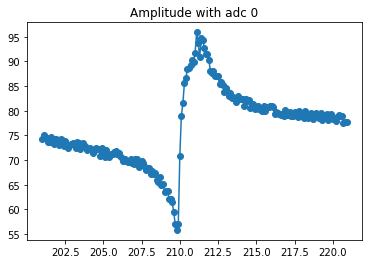

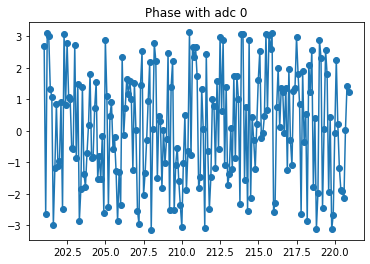

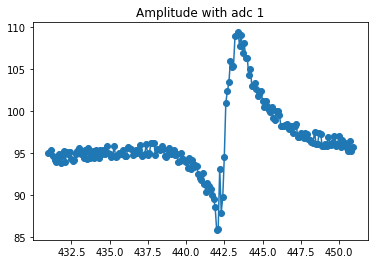

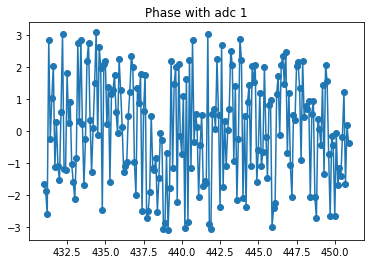

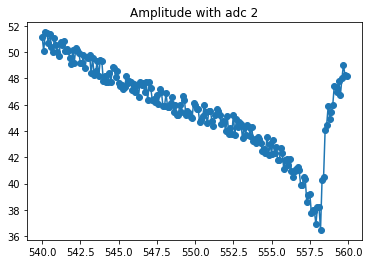

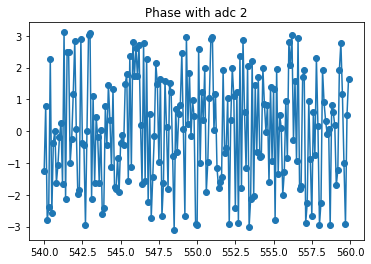

In [6]:
for i in range(len(config["ro_chs"])):
    plt.title(f"Amplitude with adc {i}")
    plt.plot(freqs+config["initials"][i], results[i],'o-')
    plt.show()
    plt.title(f"Phase with adc {i}")
    plt.plot(freqs+config["initials"][i], phase[i],'o-')
    plt.show()

## Standard readout bitstream

In [8]:
soc = qick.QickSoc()
soccfg = soc
print(soc)


QICK configuration:

	Board: ZCU111

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 0, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 0, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 0, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 1, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 1, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC tile 1, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	6:	axis_signal_gen_v4 - tProc out

In [9]:
class SingleToneSpectroscopyProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        self.declare_gen(ch=cfg["res_ch"], nqz=cfg['nqz']) #Readout
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["frequency"], gen_ch=cfg["res_ch"])
        
        freq=self.freq2reg(cfg["frequency"], gen_ch=cfg["res_ch"], ro_ch=0)  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=freq, phase=0, gain=cfg["res_gain"],
                                length=cfg["readout_length"])

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

  0%|          | 0/200 [00:00<?, ?it/s]

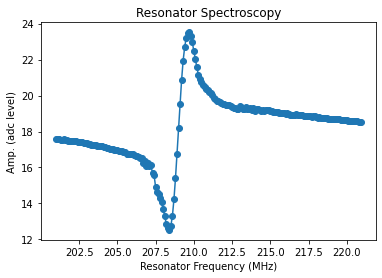

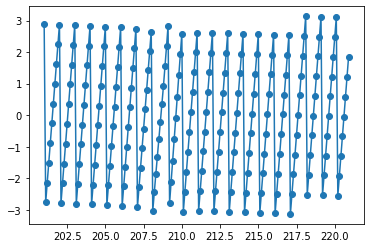

In [12]:
LO= 6900
config={
 'res_ch': 6,
 'nqz': 1,
 'readout_length': soccfg.us2cycles(1),
 'f_res': 7111 - LO,
 'res_phase': 0,
 'adc_trig_offset': 150,
 'res_gain': int(0.5*32000/0.3),
 'relax_delay': 50,
    
 'reps': 300,
 'start': 7111 - LO - 10,
 'step': 0.1,
 'expts': 200
}

fpts=config["start"] + config["step"]*np.arange(config["expts"])

plt.subplot(111,title="Resonator Spectroscopy", xlabel="Resonator Frequency (MHz)", ylabel="Amp. (adc level)")

amps=[]
phases=[]

for f in tqdm(fpts):
    config["frequency"]=f
    rspec=SingleToneSpectroscopyProgram(soccfg, config)
    avgi,avgq=rspec.acquire(soc, load_pulses=True)
    amp=np.abs(avgi[0][0]+1j*avgq[0][0])
    phase=np.angle(avgi[0][0]+1j*avgq[0][0])
    amps.append(amp)
    phases.append(phase)
amps=np.array(amps)

plt.plot(fpts, amps,'o-')
plt.show()

plt.plot(fpts, phases,'o-')
plt.show()